In [2]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm
from pathlib import Path
import seaborn as sns

In [195]:
folder_path = r"C:\Users\msi\Desktop\workspace\042_materials_GNN\Data Sets for ML\Data Sets for ML"
folder = Path(folder_path)

In [196]:
df = pd.DataFrame()
for idx, p in enumerate(folder.glob("*/*/*/MergedGrainsData*")):
    df_tmp = pd.read_excel(p, header=1)
        
    percent = int(p.parts[-2][:-1])
    tmp = p.parts[-3].split("_")
    temperature = int(tmp[0])
    speed = tmp[1]
    speed = 0 if speed == "LS" else 1
    direction = int(p.parts[-4][1:])

    df_tmp["percent"] = percent
    df_tmp["temperature"] = temperature
    df_tmp["speed"] = speed
    df_tmp["direction"] = direction
    df_tmp["set_num"] = idx
    
    if idx == 0:
        df = df_tmp
    else:
        df = pd.concat([df, df_tmp], axis=0, ignore_index=True)

In [197]:
df.columns

Index(['merged ID', 'original grain id', 'phi1', 'phi', 'phi2',
       'merged grain area', 'parent Area', 'daughter Area', 'other area',
       'no. of parent grains', 'no. of daughter grains',
       'daughter grains percent', 'other daughters', 'other daughters area',
       'major axis', 'aspect ratio', 'total boundary length',
       'border boundary length', 'internal boundary length', 'GOS', 'GAM',
       'Schmid SF1', 'Schmid SF2', 'Schmid SF3', 'Schmid SF4', 'Schmid SF5',
       'Schmid SF6', 'Taylor TF1', 'Taylor TF2', 'Taylor TF3', 'Taylor TF4',
       'Taylor TF5', 'Taylor TF6', 'Twin Count for Var1',
       'Twin Count for Var2', 'Twin Count for Var3', 'Twin Count for Var4',
       'Twin Count for Var5', 'Twin Count for Var6', 'Area Twinned for Var1',
       'Area Twinned for Var2', 'Area Twinned for Var3',
       'Area Twinned for Var4', 'Area Twinned for Var5',
       'Area Twinned for Var6', 'Schmid for Var1', 'Schmid for Var2',
       'Schmid for Var3', 'Schmid for Var

In [198]:
y = (df["daughter grains percent"] > 0).astype(int).to_numpy()

In [199]:
sum(y)

np.int64(2678)

In [200]:
ID_COL = 'merged ID'
FEATURE_COLS = [
    'phi1',
    'phi',
    'phi2',
    'merged grain area',
    'major axis',
    'aspect ratio',
    'total boundary length',
    'GOS',
    'GAM',
    'Schmid SF1',
    'Schmid SF2',
    'Schmid SF3',
    'Schmid SF4',
    'Schmid SF5',
    'Schmid SF6',
    'Taylor TF1',
    'Taylor TF2',
    'Taylor TF3',
    'Taylor TF4',
    'Taylor TF5',
    'Taylor TF6',
    'Schmid for Var1',
    'Schmid for Var2',
    'Schmid for Var3',
    'Schmid for Var4',
    'Schmid for Var5',
    'Schmid for Var6',
    'percent',
    'temperature',
    'speed',
    'direction'
]
FEATURE_COLS_ACHIEVED_AFTERWARDS = [
    'no. of parent grains',
    'parent Area',
    'daughter Area',
    'other area',
    'other daughters',
    'other daughters area'
]
EDGE_COL = 'neighbor grain ids'

VAGUE_COLS = [
    'major axis',
    'aspect ratio',
    'merged grain area',
    'total boundary length'
]
FEATURE_COLS_INSIDE = [c for c in FEATURE_COLS if c not in VAGUE_COLS]

In [201]:
df[FEATURE_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19895 entries, 0 to 19894
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   phi1                   19895 non-null  float64
 1   phi                    19895 non-null  float64
 2   phi2                   19895 non-null  float64
 3   merged grain area      19895 non-null  int64  
 4   major axis             19895 non-null  float64
 5   aspect ratio           19895 non-null  float64
 6   total boundary length  19895 non-null  int64  
 7   GOS                    19895 non-null  float64
 8   GAM                    19895 non-null  float64
 9   Schmid SF1             19895 non-null  float64
 10  Schmid SF2             19895 non-null  float64
 11  Schmid SF3             19895 non-null  float64
 12  Schmid SF4             19895 non-null  float64
 13  Schmid SF5             19895 non-null  float64
 14  Schmid SF6             19895 non-null  float64
 15  Ta

In [203]:
df[FEATURE_COLS].describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,percent,temperature,speed,direction
count,19895.000000,19895.000000,19895.000000,19895.00000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,...,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.00000,19895.000000,19895.000000
mean,29.120824,288.245686,28.832517,325.75049,21.244542,2.033940,87.887308,1.263270,0.866040,0.332478,...,0.178527,0.178735,0.169278,0.169258,0.120202,0.120015,4.841066,238.18673,0.630259,55.673787
std,26.438818,121.361371,28.352330,855.83364,19.706067,1.074106,106.378735,1.206655,0.514919,0.132308,...,0.261146,0.261554,0.271687,0.271737,0.261997,0.261373,1.993725,115.31642,0.482747,43.716888
min,0.001707,0.001946,0.023277,10.00000,3.685321,1.000000,14.000000,0.070525,0.129033,0.000084,...,-0.499920,-0.499964,-0.499985,-0.499807,-0.499997,-0.499496,3.000000,25.00000,0.000000,0.000000
25%,12.136830,314.666119,11.845387,35.00000,9.122364,1.421137,34.000000,0.460354,0.516037,0.238058,...,0.012569,0.011854,0.000826,0.000927,-0.068930,-0.067074,3.000000,175.00000,0.000000,0.000000
50%,25.605384,339.737126,24.505183,103.00000,15.581967,1.742125,58.000000,0.841719,0.745494,0.367902,...,0.247278,0.247817,0.243143,0.241900,0.147296,0.146205,3.000000,225.00000,1.000000,90.000000
75%,44.762547,351.808186,43.755890,287.00000,26.094585,2.266633,100.000000,1.625085,1.057264,0.444374,...,0.396695,0.396278,0.397310,0.396644,0.352671,0.353367,7.000000,325.00000,1.000000,90.000000
max,359.975532,359.998335,359.990164,29114.00000,246.901174,20.813044,2365.000000,13.286989,7.579747,0.499994,...,0.499829,0.499907,0.499923,0.499828,0.499997,0.499994,7.000000,425.00000,1.000000,90.000000


### Data Analysis

#### 1. Correlation

In [204]:
# new df with the answer
df_with_y = pd.concat([df, pd.Series(y, name="twin_or_not")], axis=1)

# delete columns that cannot be calculated in correlation analysis
df_with_y = df_with_y._get_numeric_data()

df_with_y.head()

,merged ID,original grain id,phi1,phi,phi2,merged grain area,parent Area,daughter Area,other area,no. of parent grains,...,Rank for Var4,Rank for Var5,Rank for Var6,neighbor grains count,percent,temperature,speed,direction,set_num,twin_or_not
0,1,1,51.992588,340.060929,7.927710,13,13,0,0,1,...,4,6,5,2,3,125,0,0,0,0
1,2,2,48.614823,347.530536,19.772951,18,18,0,0,1,...,2,6,5,3,3,125,0,0,0,0
2,3,5,40.321865,353.327411,25.271908,27,27,0,0,1,...,5,6,4,3,3,125,0,0,0,0
3,4,7,44.155840,351.273455,10.917894,14,14,0,0,1,...,3,1,2,2,3,125,0,0,0,0
4,5,10,18.402519,309.171717,18.854361,30,30,0,0,1,...,2,5,6,2,3,125,0,0,0,0


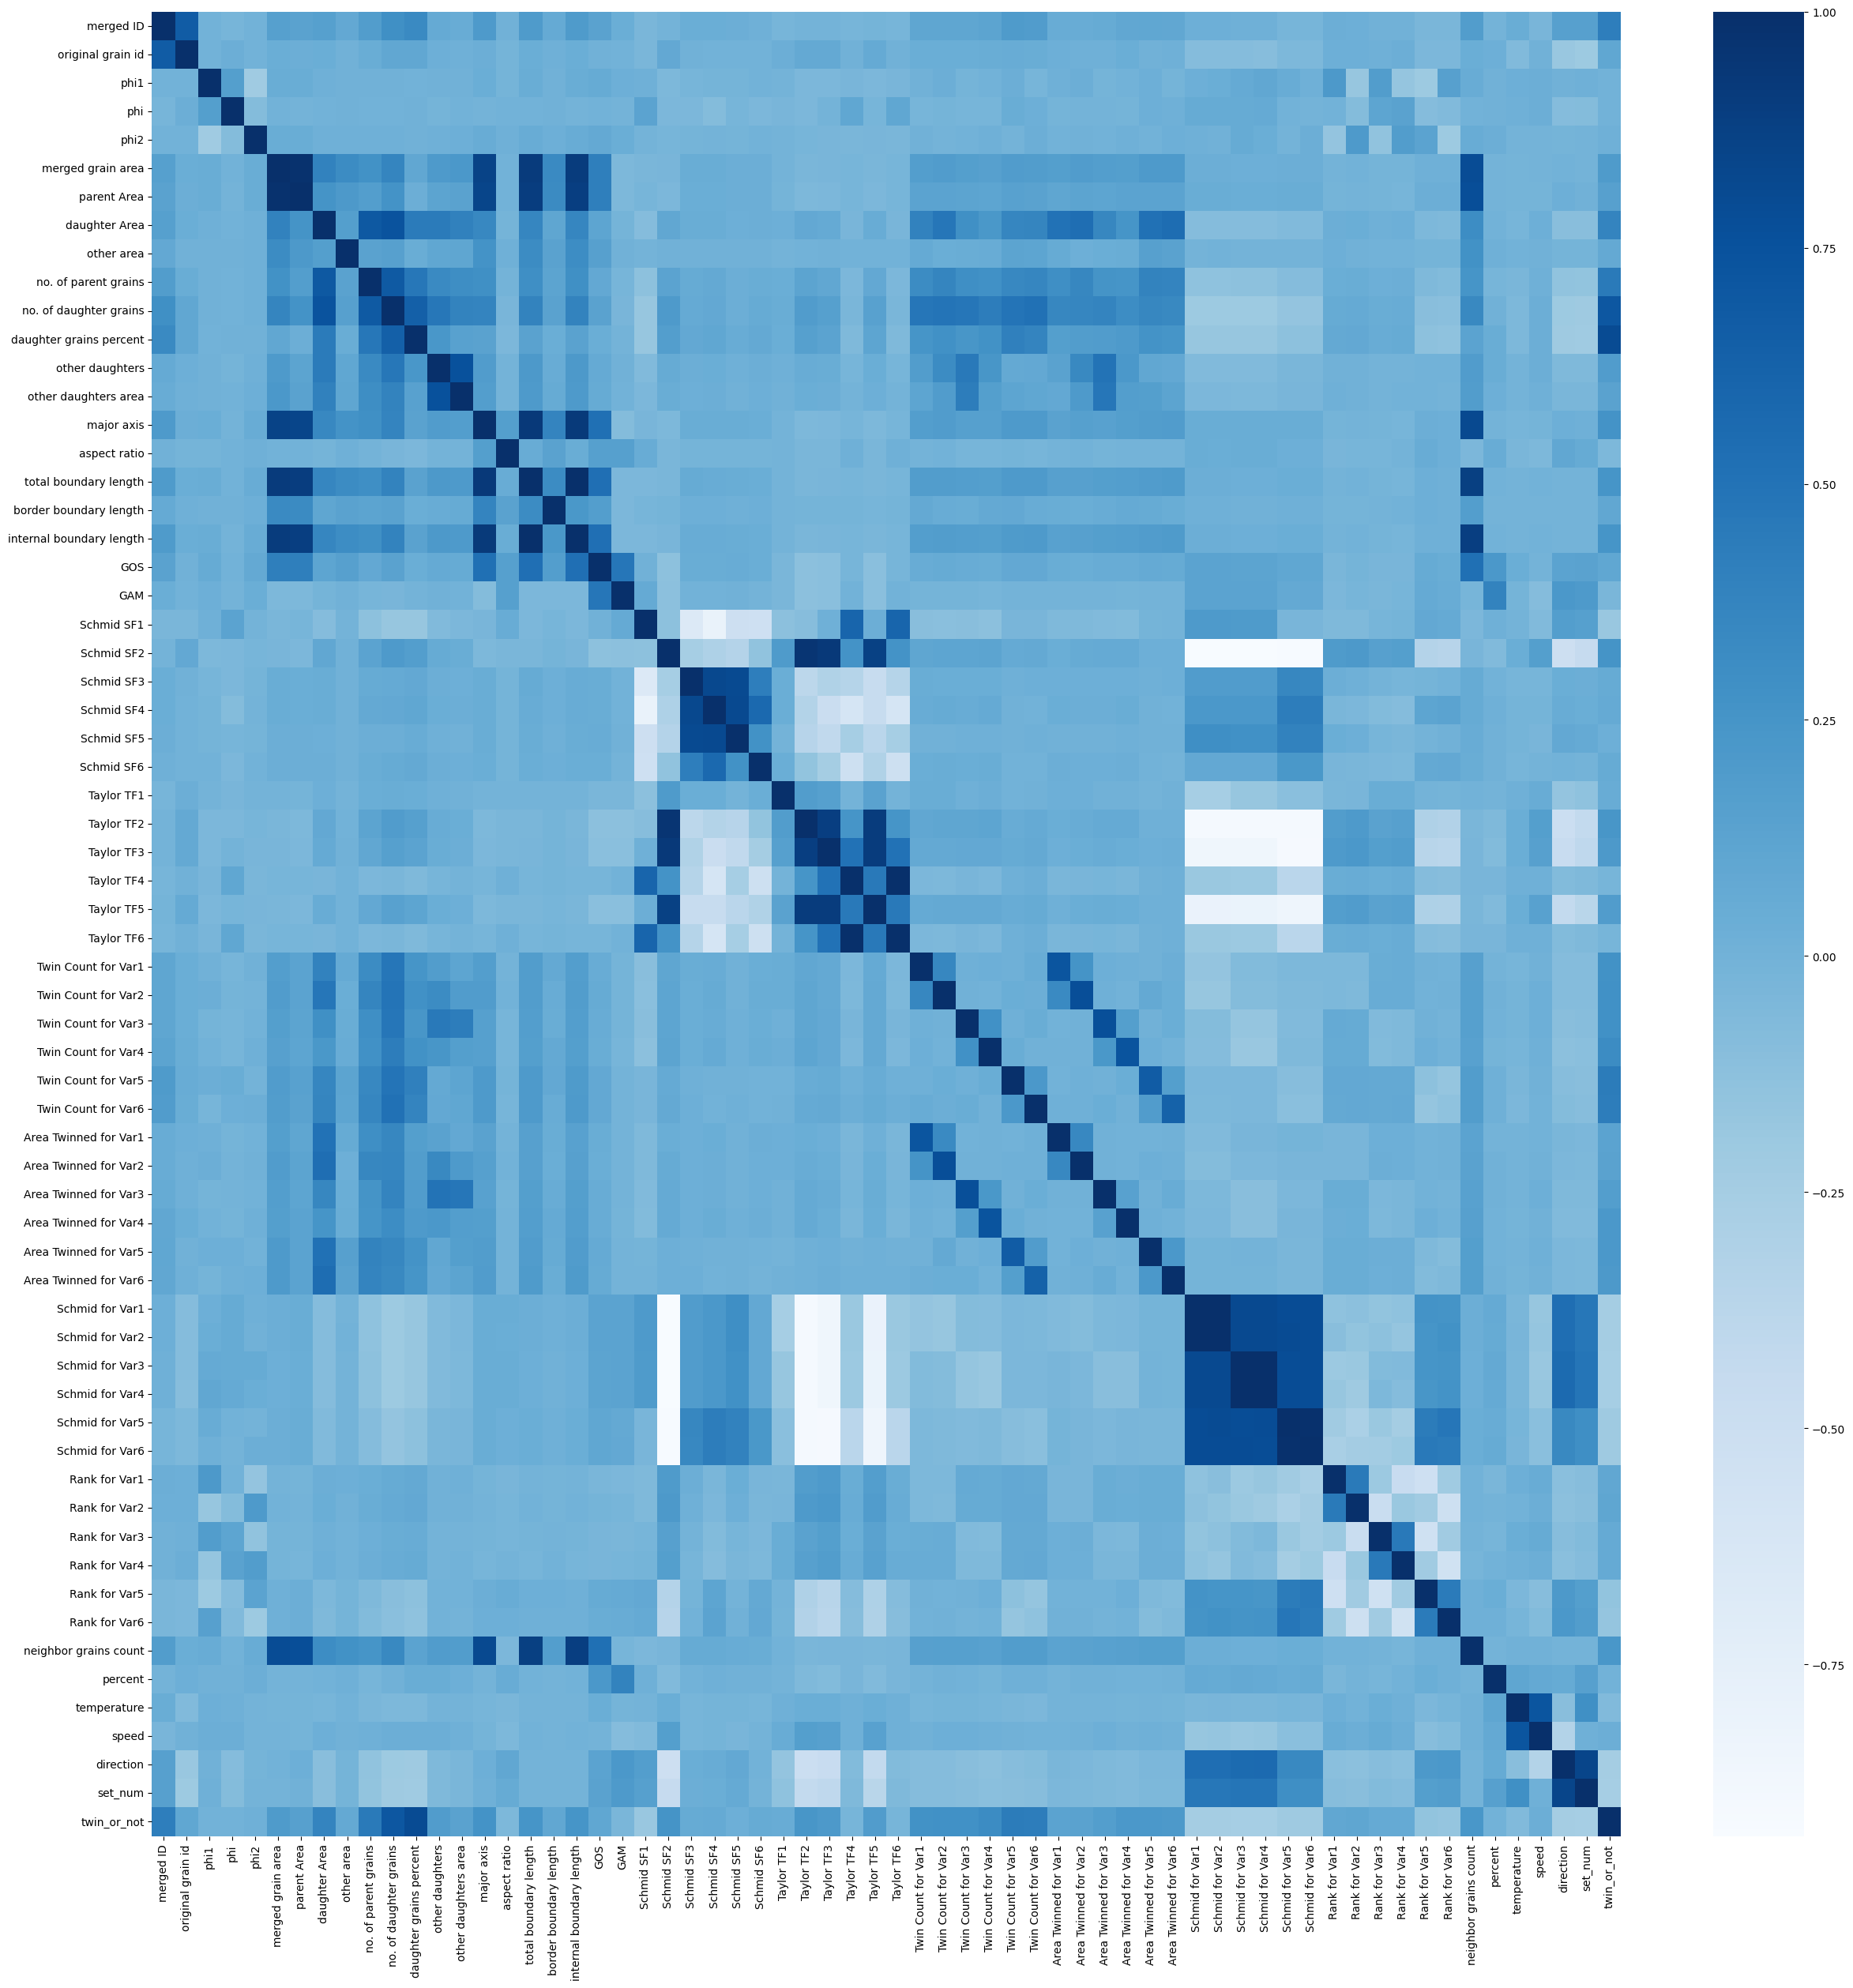

In [205]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_with_y.corr(), cmap="Blues")
plt.show()

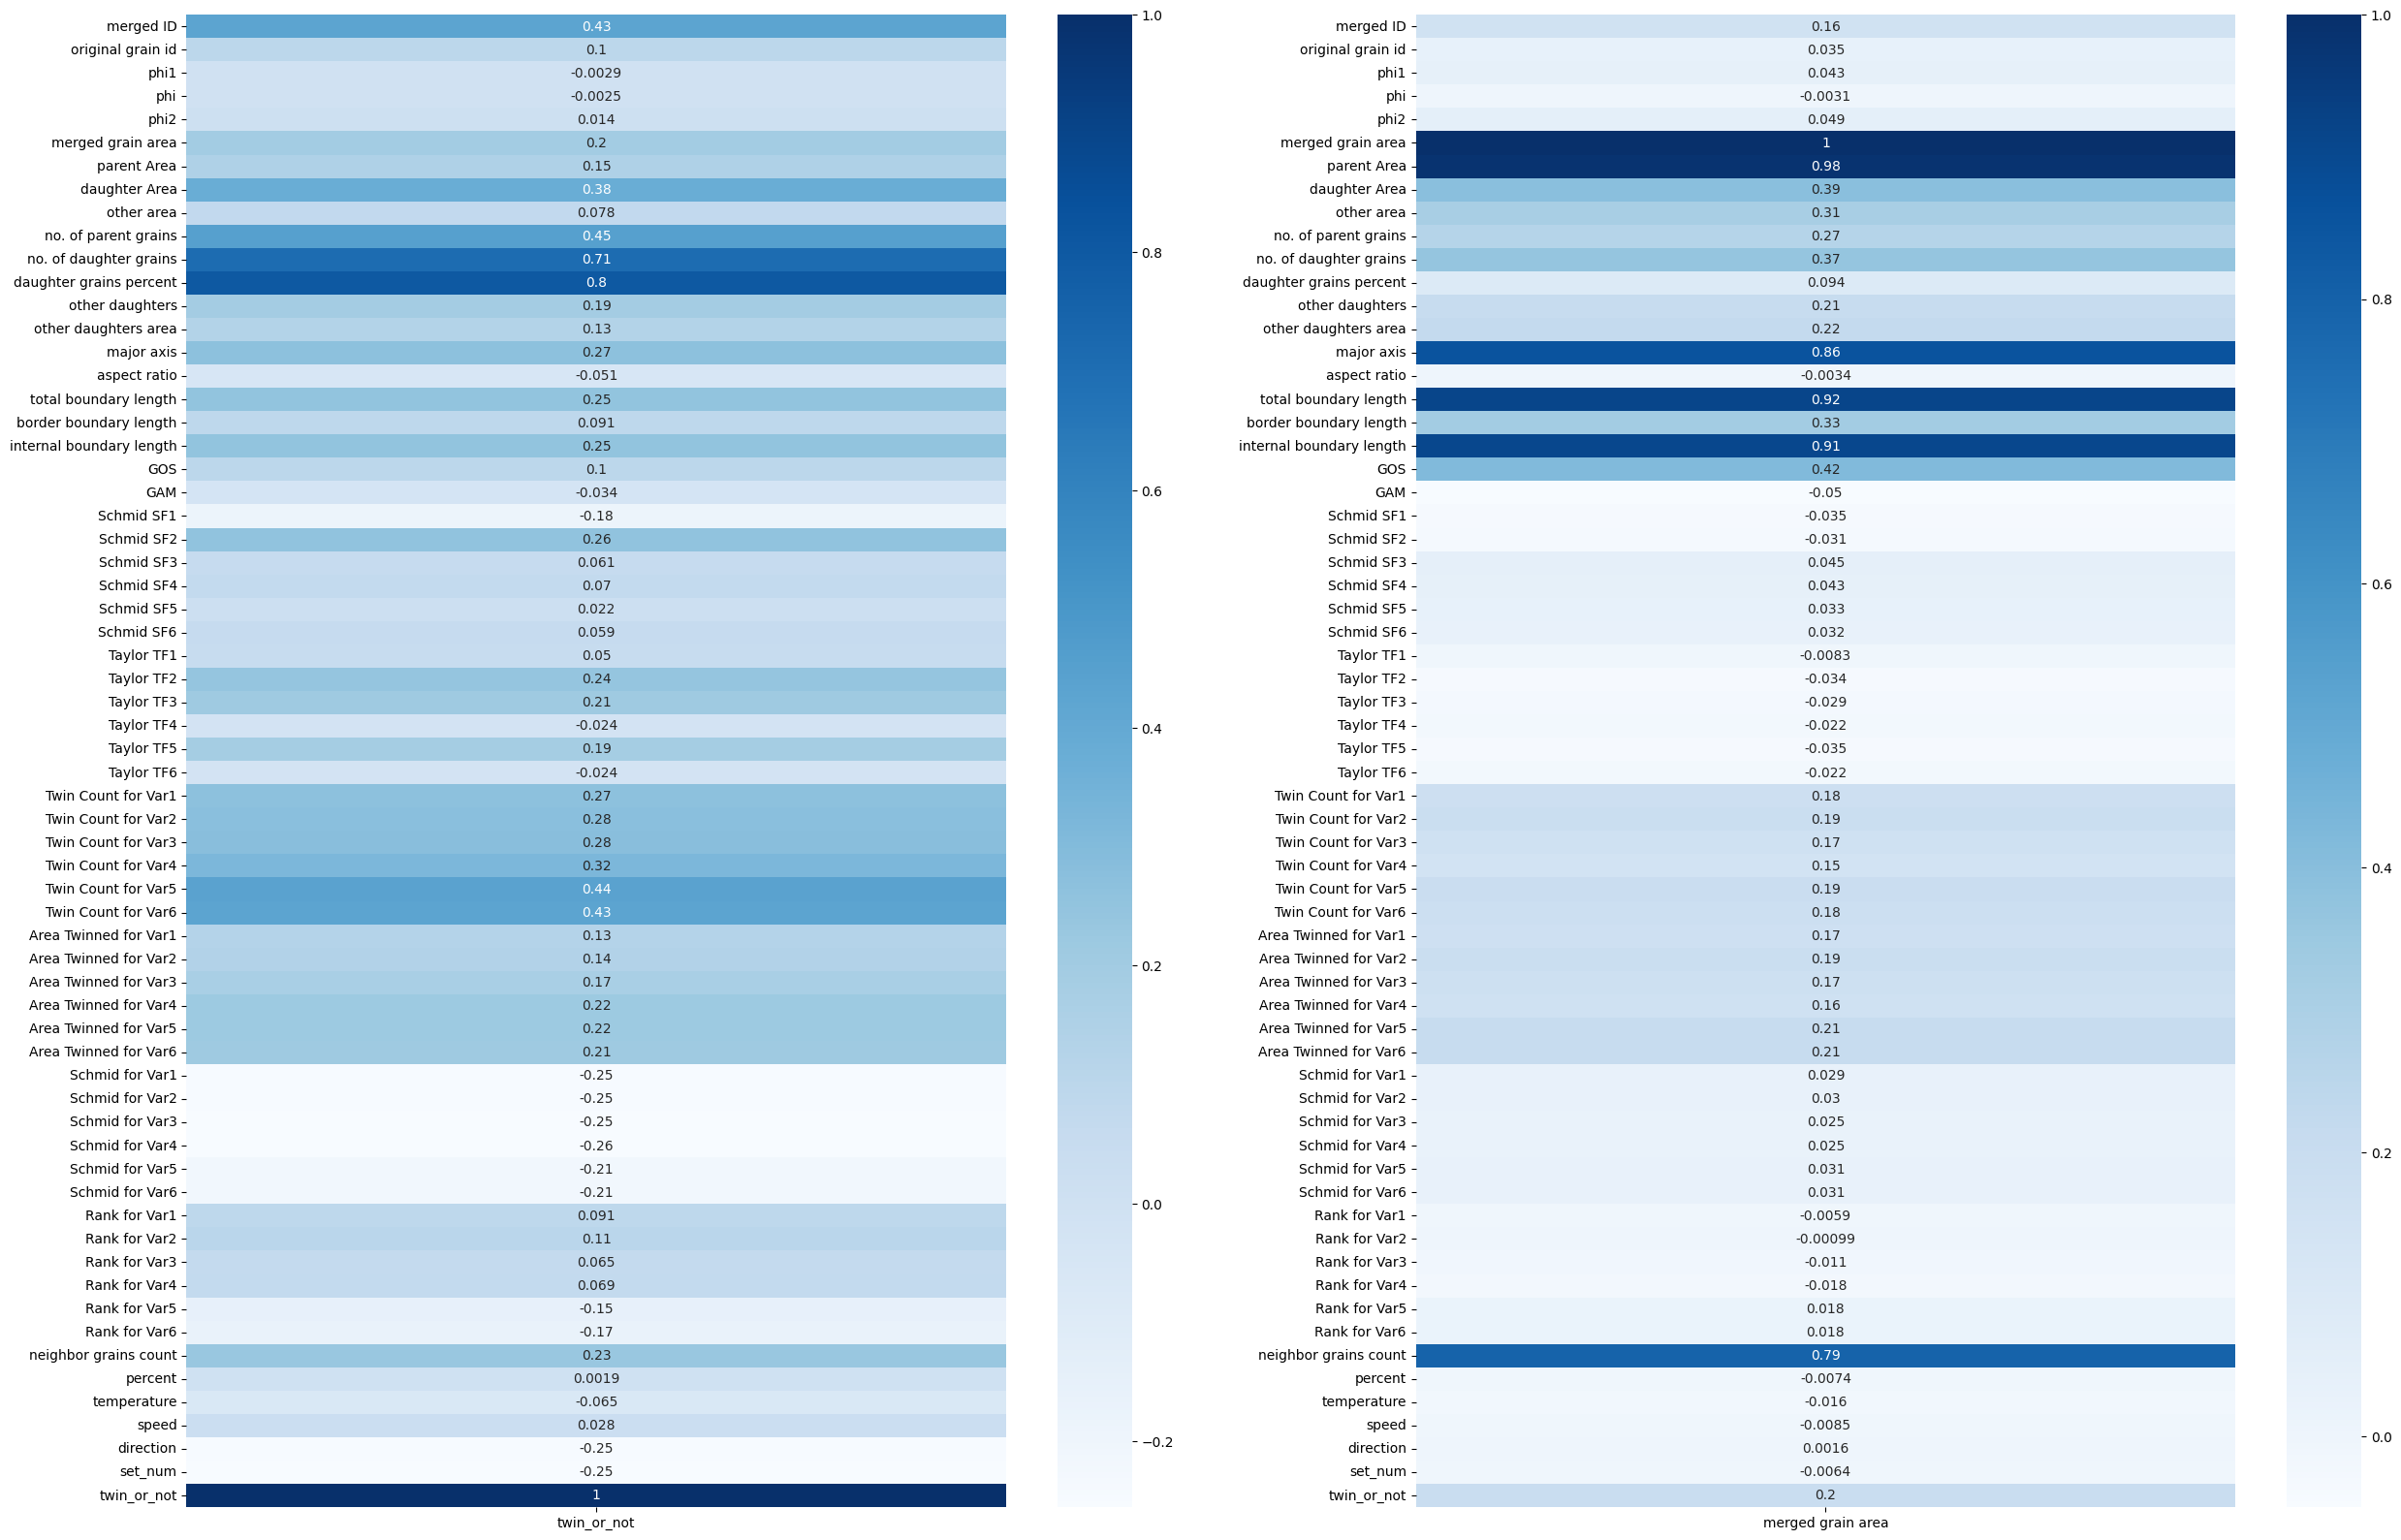

In [206]:
heatmap_data = df_with_y.corr()
h_1 = pd.DataFrame(heatmap_data["twin_or_not"])
h_2 = pd.DataFrame(heatmap_data["merged grain area"])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30, 20)
sns.heatmap(h_1, cmap="Blues", annot=True, ax=axes[0])
sns.heatmap(h_2, cmap="Blues", annot=True, ax=axes[1])

file_name = "correlation.png"
plt.savefig(file_name, bbox_inches="tight")

plt.show()

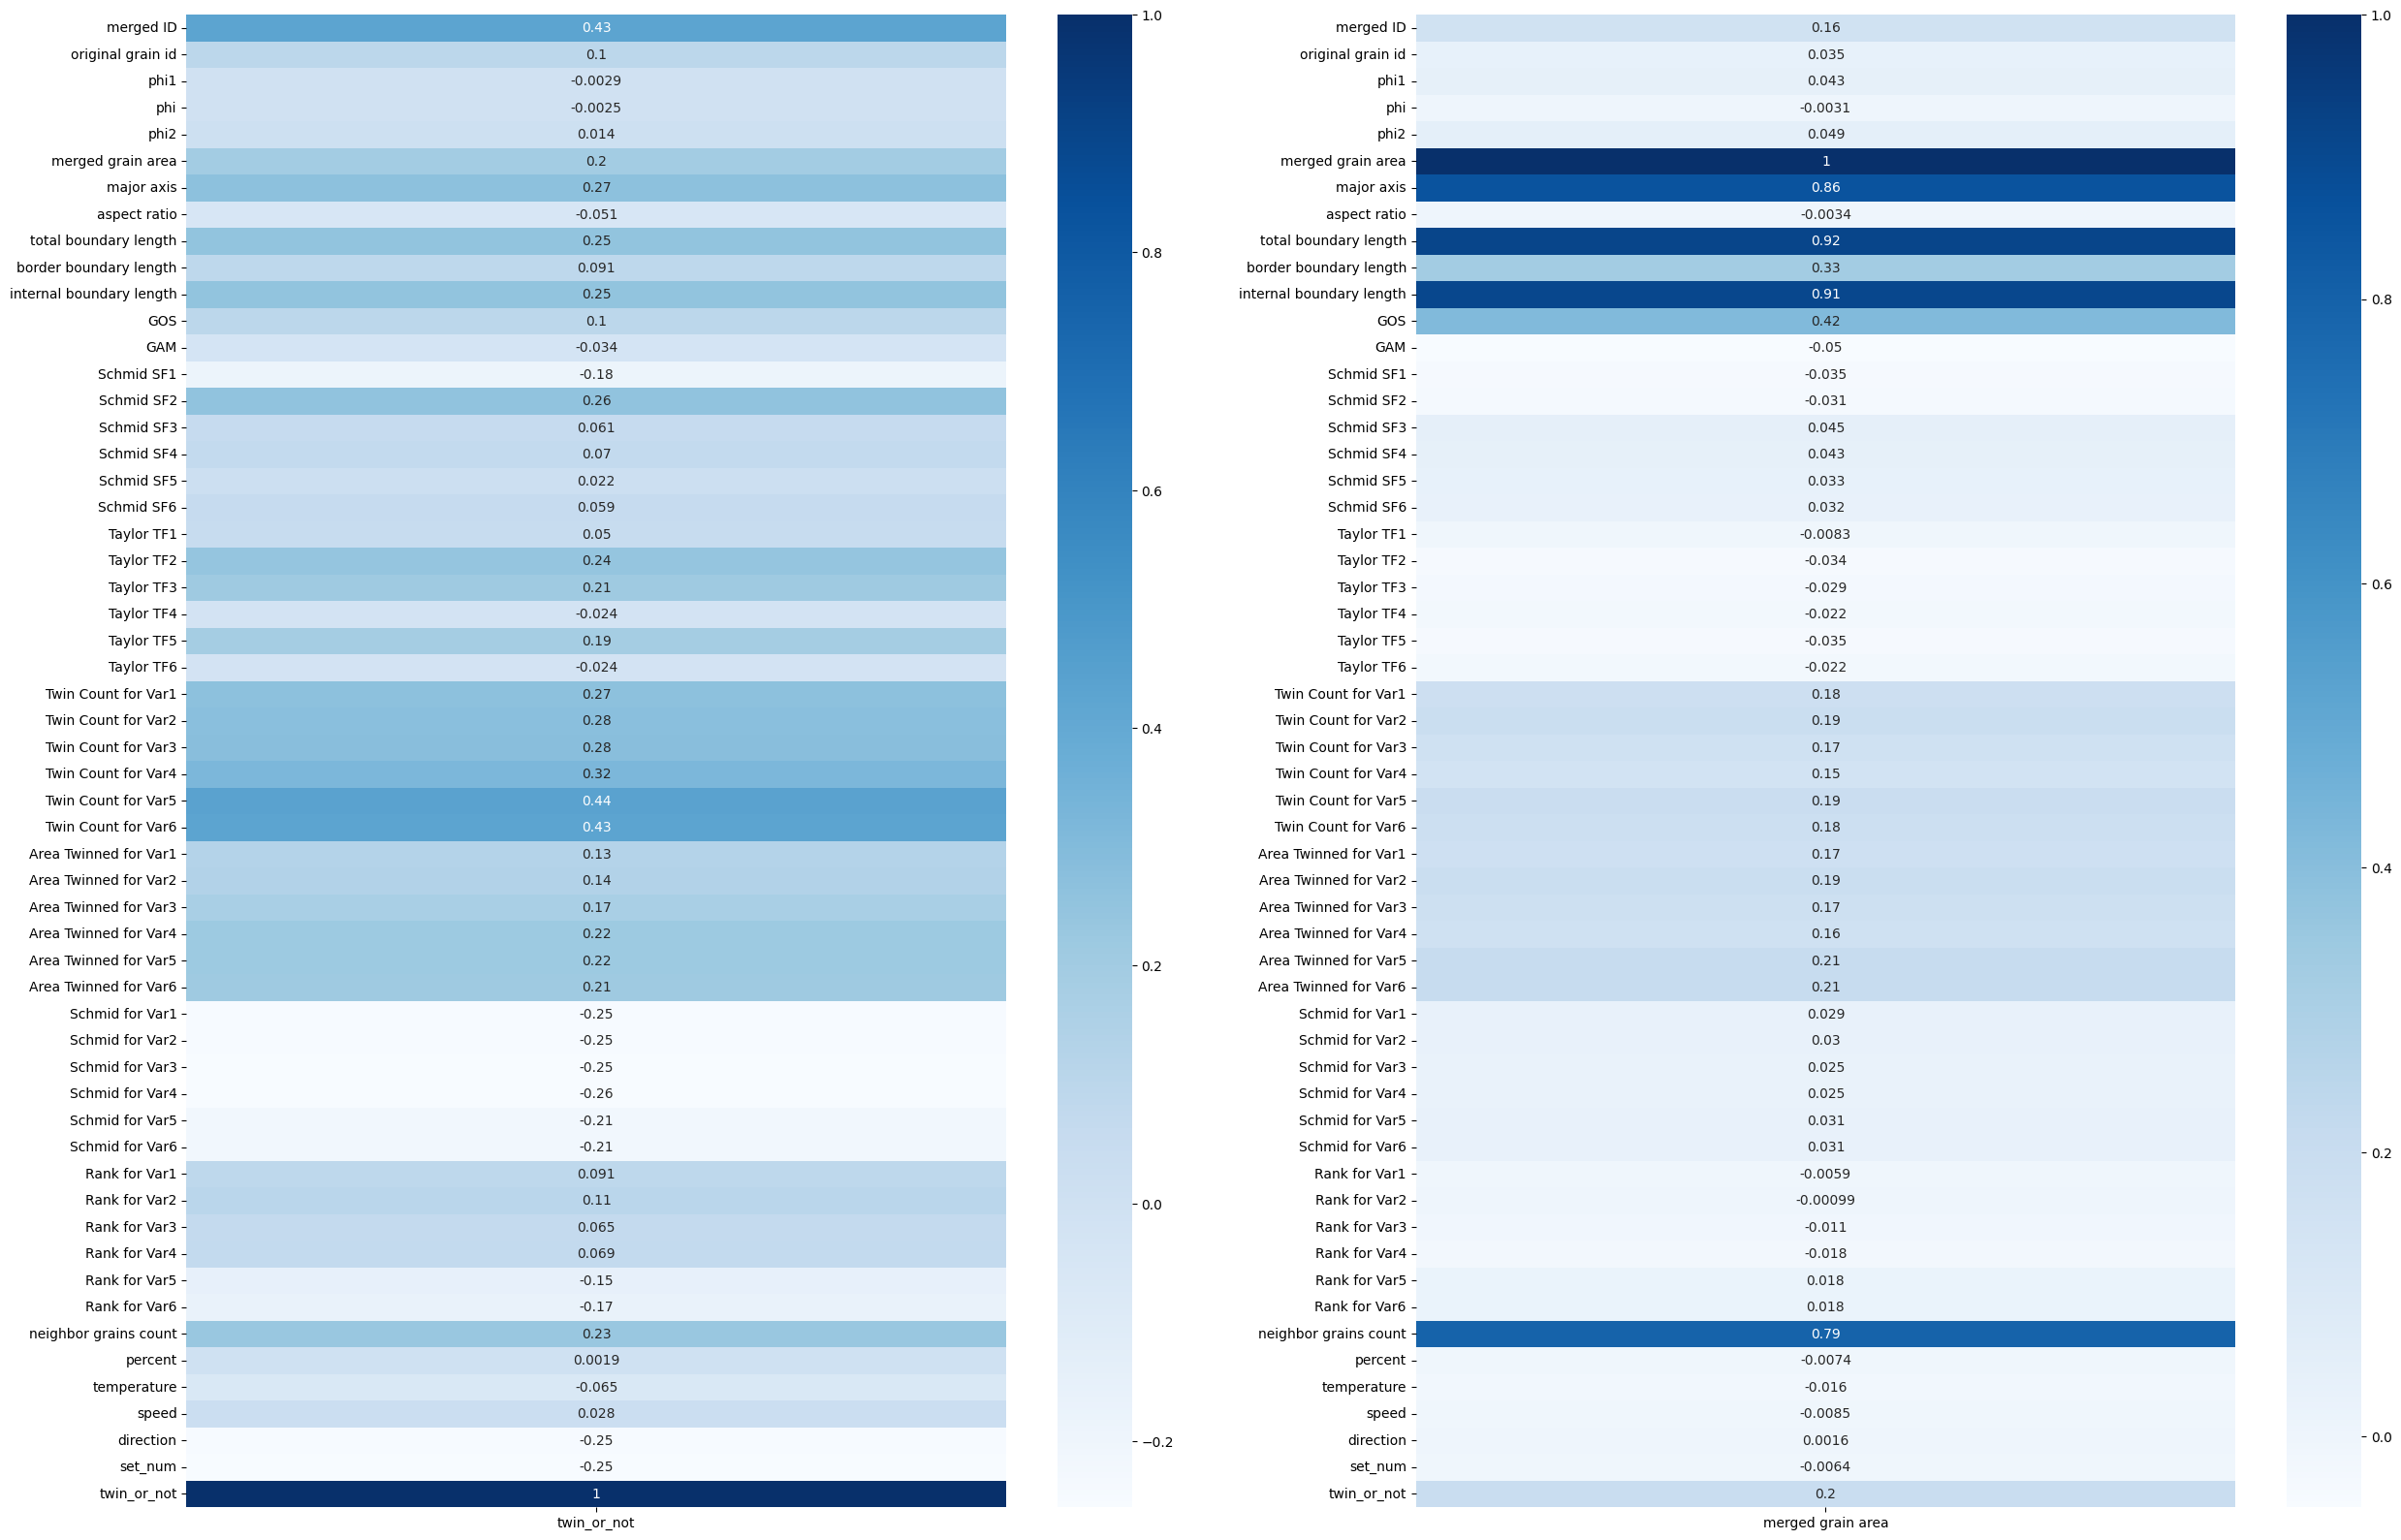

In [207]:
df_with_y_and_deleted_impactful_columns = df_with_y.drop(columns=FEATURE_COLS_ACHIEVED_AFTERWARDS + ["no. of daughter grains", "daughter grains percent"])
heatmap_data = df_with_y_and_deleted_impactful_columns.corr()

h_1 = pd.DataFrame(heatmap_data["twin_or_not"])
h_2 = pd.DataFrame(heatmap_data["merged grain area"])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30, 20)
sns.heatmap(h_1, cmap="Blues", annot=True, ax=axes[0])
sns.heatmap(h_2, cmap="Blues", annot=True, ax=axes[1])

file_name = "correlation_without_impactful_columns.png"
plt.savefig(file_name, bbox_inches="tight")

plt.show()

In [208]:
edges = []
edge_info = df[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info):
    for e in e_list:
        df_set = df[df["set_num"] == df.iloc[i]["set_num"]]
        node = df_set.index[df_set["merged ID"] == e].to_list()[0]
        
        new = [i, node]
        edges.append(new)
        
edge_index = torch.Tensor(edges).to(dtype=torch.long).t()

In [209]:
df.tail()

,merged ID,original grain id,phi1,phi,phi2,merged grain area,parent Area,daughter Area,other area,no. of parent grains,...,Rank for Var4,Rank for Var5,Rank for Var6,neighbor grains count,neighbor grain ids,percent,temperature,speed,direction,set_num
19890,919,538,39.399561,347.935385,17.936780,52,30,0,22,1,...,3,5,6,3,"532,545,547",7,425,1,90,27
19891,920,746,16.728591,0.639074,36.101943,309,233,76,0,1,...,4,2,1,7,"696,698,705,724,728,746,922",7,425,1,90,27
19892,921,754,41.199993,358.019199,15.227974,772,590,182,0,1,...,1,4,6,9,"679,682,686,707,711,720,723,763,808",7,425,1,90,27
19893,922,803,29.561427,1.504001,18.417803,1600,1068,0,532,1,...,1,5,6,18,"687,692,698,706,715,728,735,739,766,769,770,77...",7,425,1,90,27
19894,923,839,49.563917,336.054992,6.881720,35,21,14,0,1,...,5,6,3,1,896,7,425,1,90,27


In [343]:
np.random.seed(1105)

train_ratio = 0.8

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 15915
len(val_indices) = 1990
len(test_indices) = 1990
split done!


In [344]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [345]:
FEATURE_COLS_COMBINED = FEATURE_COLS + FEATURE_COLS_ACHIEVED_AFTERWARDS

### Focus on the samples classified `wrong`

In [355]:
X_train = df.loc[train_mask.numpy(), FEATURE_COLS_COMBINED]
X_val = df.loc[val_mask.numpy(), FEATURE_COLS_COMBINED]
X_test = df.loc[test_mask.numpy(), FEATURE_COLS_COMBINED]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (15915, 37) / (1990, 37) / (1990, 37)
y_train.shape = (15915,) / (1990,) / (1990,)


In [356]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [357]:
X = np.zeros_like(df[FEATURE_COLS_COMBINED])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [358]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [359]:
data

Data(x=[19895, 37], edge_index=[2, 107484], y=[19895], train_mask=[19895], val_mask=[19895], test_mask=[19895])

In [361]:
pd.DataFrame(X, columns=FEATURE_COLS_COMBINED).describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,percent,temperature,speed,direction,no. of parent grains,parent Area,daughter Area,other area,other daughters,other daughters area
count,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,...,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000
mean,-0.002250,-0.000063,0.002114,0.002729,0.003605,0.000826,0.001525,0.003949,0.001588,-0.003218,...,0.001909,-0.000805,0.001245,-0.002332,0.000522,0.003154,-0.000479,-0.000733,-0.000705,-0.001583
std,1.003738,0.999527,1.002992,0.995452,1.009343,0.992778,0.995571,1.001371,1.000073,1.002071,...,1.000179,0.996510,0.999690,1.000597,1.018653,0.996070,0.966371,0.966225,1.019578,0.948796
min,-1.107744,-2.374025,-1.017041,-0.364533,-0.895777,-0.954828,-0.689968,-0.985878,-1.429823,-2.520698,...,-0.921687,-1.843064,-1.303919,-1.276601,-0.183848,-0.364349,-0.144428,-0.063742,-0.077553,-0.052017
25%,-0.647040,0.217535,-0.598822,-0.335454,-0.617292,-0.565578,-0.502793,-0.662369,-0.678186,-0.718339,...,-0.921687,-0.546835,-1.303919,-1.276601,-0.183848,-0.334226,-0.144428,-0.063742,-0.077553,-0.052017
50%,-0.135712,0.424019,-0.150969,-0.256361,-0.286432,-0.268894,-0.278183,-0.345884,-0.232537,0.265074,...,-0.921687,-0.114759,0.766919,0.783330,-0.183848,-0.253897,-0.144428,-0.063742,-0.077553,-0.052017
75%,0.591582,0.523435,0.530043,-0.042344,0.252023,0.215900,0.114884,0.304210,0.372982,0.844258,...,1.084968,0.749394,0.766919,0.783330,-0.183848,-0.036759,-0.144428,-0.063742,-0.077553,-0.052017
max,12.558506,0.590889,11.717143,33.487426,11.561715,17.358032,21.312434,9.982114,13.040906,1.265505,...,1.084968,1.613546,0.766919,0.783330,28.874377,35.914046,40.532410,79.526374,59.644677,66.005871


In [362]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

In [363]:
rf_model = RandomForestClassifier(
    # n_estimators=30,
    # max_depth=10,
    # random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


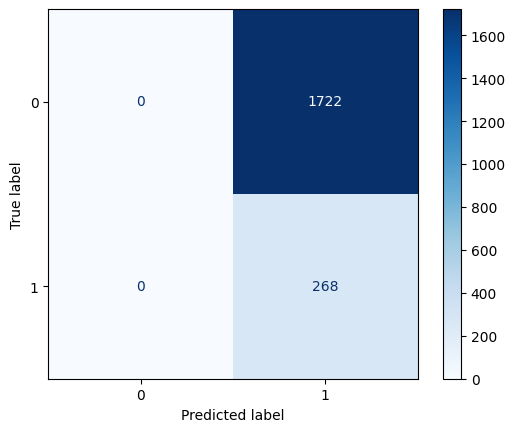

Accuracy: 0.1347
Precision: 0.1347
Recall: 1.0000
f1 score: 0.2374


In [364]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

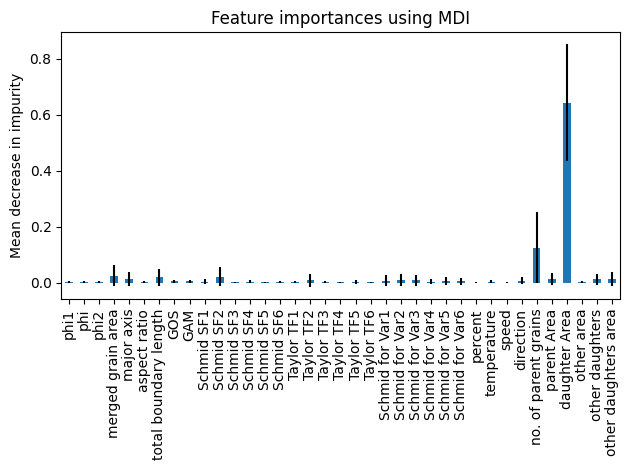

In [365]:
importances = rf_model.feature_importances_
forest_std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=FEATURE_COLS_COMBINED)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


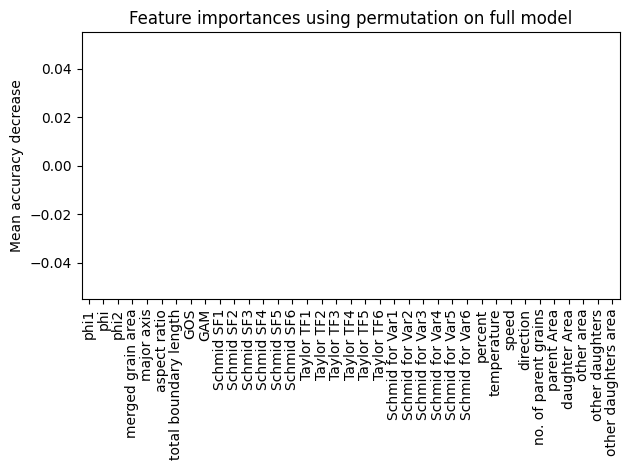

In [366]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=30, random_state=1105, n_jobs=5
)
pm_importances = pd.Series(result.importances_mean, index=FEATURE_COLS_COMBINED)

fig, ax = plt.subplots()
pm_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [367]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


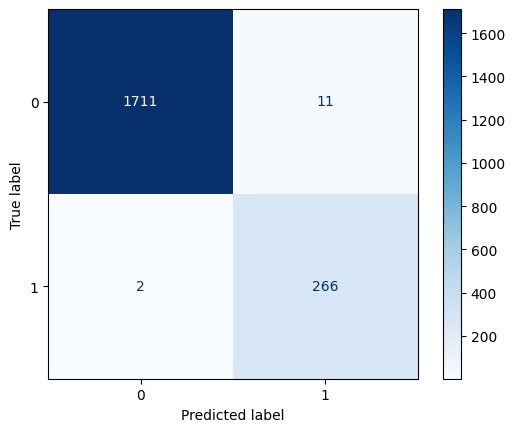

Accuracy: 0.9935
Precision: 0.9603
Recall: 0.9925
f1 score: 0.9761


In [368]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [369]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 30.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


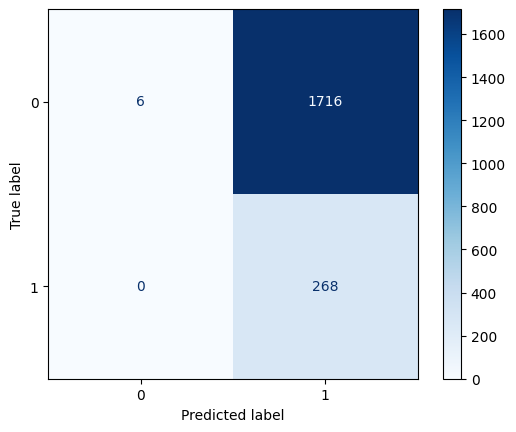

Accuracy: 0.1377
Precision: 0.1351
Recall: 1.0000
f1 score: 0.2380


In [370]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [371]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [372]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,401
MLP model number of params: 342,401


In [373]:
weight = torch.Tensor([1.0, 2.5])
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7382 / Val_loss: 0.4277
Epoch: 002, Train_loss: 0.5223 / Val_loss: 0.4011
Epoch: 003, Train_loss: 0.4361 / Val_loss: 0.4114
Epoch: 004, Train_loss: 0.4129 / Val_loss: 0.4227
Epoch: 005, Train_loss: 0.4086 / Val_loss: 0.4299
Epoch: 006, Train_loss: 0.4125 / Val_loss: 0.4333
Epoch: 007, Train_loss: 0.4151 / Val_loss: 0.4333
Epoch: 008, Train_loss: 0.4168 / Val_loss: 0.4308
Epoch: 009, Train_loss: 0.4166 / Val_loss: 0.4267
Epoch: 010, Train_loss: 0.4151 / Val_loss: 0.4214
Epoch: 011, Train_loss: 0.4131 / Val_loss: 0.4156
Epoch: 012, Train_loss: 0.4089 / Val_loss: 0.4099
Epoch: 013, Train_loss: 0.4097 / Val_loss: 0.4047
Epoch: 014, Train_loss: 0.4085 / Val_loss: 0.4002
Epoch: 015, Train_loss: 0.4039 / Val_loss: 0.3966
Epoch: 016, Train_loss: 0.4019 / Val_loss: 0.3939
Epoch: 017, Train_loss: 0.4016 / Val_loss: 0.3921
Epoch: 018, Train_loss: 0.4008 / Val_loss: 0.3911
Epoch: 019, Train_loss: 0.3987 / Val_loss: 0.3907
Epoch: 020, Train_loss: 0.4004 / Val_loss: 0.3905


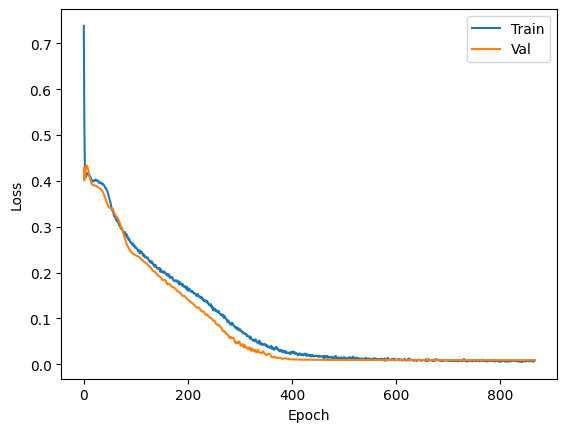

In [374]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

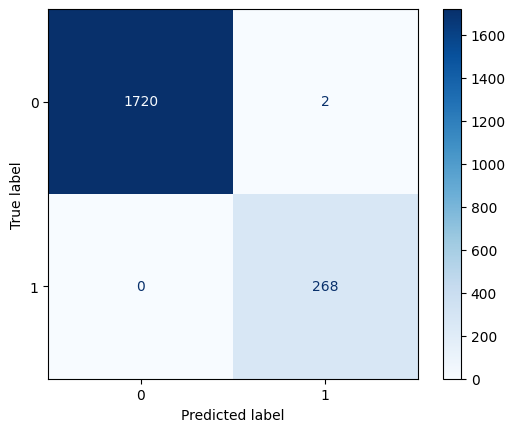

Accuracy: 0.9990
Precision: 0.9926
Recall: 1.0000
f1 score: 0.9963


In [375]:
model.eval()
with torch.no_grad():
    out_mlp = model(data.x[data.test_mask])
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred_mlp = F.sigmoid(out_mlp).round()

y_true = data.y[data.test_mask].numpy()
y_pred = pred_mlp.numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()


print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [376]:
import shap

shap.initjs()

shap_data = data.x[data.train_mask]
background = shap_data[np.random.choice(shap_data.shape[0], 2000, replace=False)]
shap_test = data.x[data.test_mask][np.random.choice(data.x[data.test_mask].shape[0], 200, replace=False)]

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(shap_test, check_additivity=False)

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


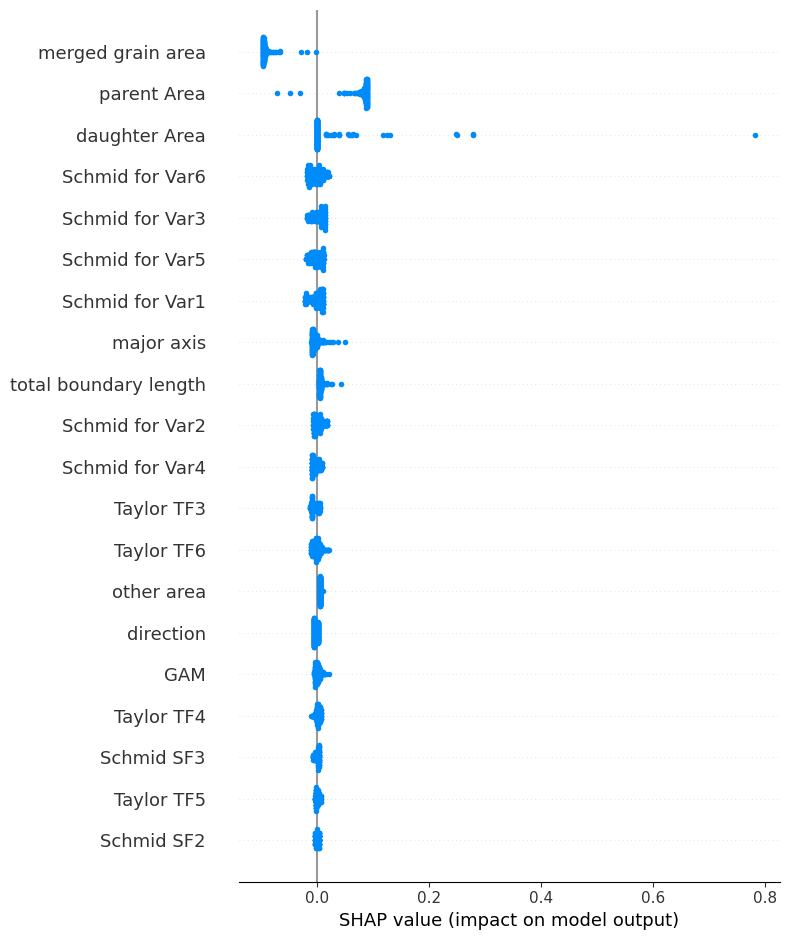

In [378]:
# exp = shap.Explanation(shap_values.squeeze(), feature_names=FEATURE_COLS)
# shap.plots.beeswarm(exp, color=['red', 'blue'])

shap.summary_plot(shap_values.squeeze(), feature_names=FEATURE_COLS_COMBINED)

In [379]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,401
GCN model number of params: 342,401


In [380]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.6280 / Val_loss: 0.6327
Epoch: 002, Train_loss: 0.5125 / Val_loss: 0.5228
Epoch: 003, Train_loss: 0.5279 / Val_loss: 0.5384
Epoch: 004, Train_loss: 0.4945 / Val_loss: 0.5022
Epoch: 005, Train_loss: 0.4521 / Val_loss: 0.4563
Epoch: 006, Train_loss: 0.4247 / Val_loss: 0.4331
Epoch: 007, Train_loss: 0.4193 / Val_loss: 0.4216
Epoch: 008, Train_loss: 0.4251 / Val_loss: 0.4344
Epoch: 009, Train_loss: 0.4308 / Val_loss: 0.4344
Epoch: 010, Train_loss: 0.4219 / Val_loss: 0.4264
Epoch: 011, Train_loss: 0.4146 / Val_loss: 0.4161
Epoch: 012, Train_loss: 0.4063 / Val_loss: 0.4074
Epoch: 013, Train_loss: 0.4051 / Val_loss: 0.4056
Epoch: 014, Train_loss: 0.4035 / Val_loss: 0.4043
Epoch: 015, Train_loss: 0.4060 / Val_loss: 0.4056
Epoch: 016, Train_loss: 0.4053 / Val_loss: 0.4115
Epoch: 017, Train_loss: 0.4043 / Val_loss: 0.4022
Epoch: 018, Train_loss: 0.4031 / Val_loss: 0.4019
Epoch: 019, Train_loss: 0.4027 / Val_loss: 0.4002
Epoch: 020, Train_loss: 0.3984 / Val_loss: 0.3979


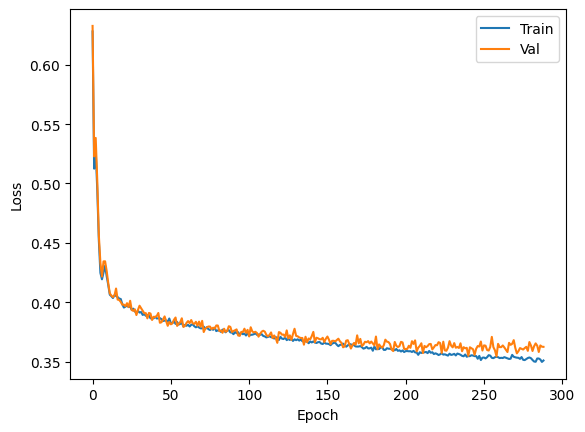

In [381]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [382]:
model.eval()
# pred = out.argmax(dim=1)  # Use the class with highest probability.
with torch.no_grad():
    out_gcn = model(data.x, data.edge_index)
pred_gcn = F.sigmoid(out_gcn).round()

y_pred = pred_gcn[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

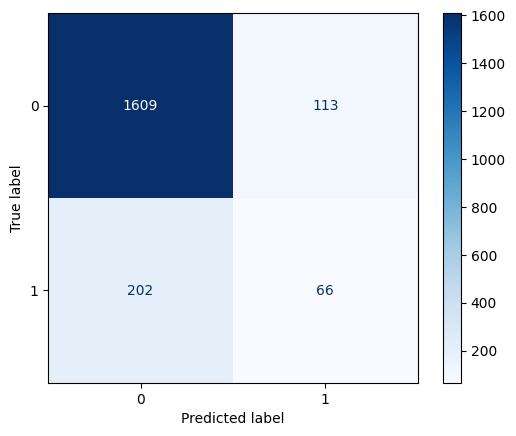

Accuracy: 0.8417
Precision: 0.3687
Recall: 0.2463
f1 score: 0.2953


In [383]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### Data analysis for `wrong` samples

In [278]:
y_true.shape

(1990,)

In [279]:
pred_mlp.shape

torch.Size([1990, 1])

In [281]:
pred_gcn[data.test_mask].shape

torch.Size([1990])

In [305]:
mlp = pred_mlp.squeeze().numpy()

mlp_fn = np.where(
    (y_true == 1) &
    (mlp == 0)
)[0]

mlp_fp = np.where(
    (y_true == 0) &
    (mlp == 1)
)[0]

mlp_f = np.where(
    y_true != mlp
)[0]
print(mlp_f)

# the number of wrong predictions shoule be 165
assert len(mlp_f) == 165
assert len(mlp_f) == len(mlp_fn) + len(mlp_fp)
assert len(set(mlp_fp).intersection(set(mlp_fn))) == 0

[  11   43   49   51   53   54  100  112  117  120  121  122  125  130
  133  136  160  165  168  169  170  173  176  188  191  204  206  229
  234  235  237  240  243  248  249  263  283  287  291  295  299  300
  313  315  321  328  333  349  354  358  360  365  379  409  413  414
  415  416  419  427  428  432  437  457  472  475  481  482  490  492
  500  503  505  510  517  522  527  564  566  567  568  569  570  571
  577  588  596  600  602  608  609  610  613  618  631  646  656  657
  658  659  661  665  667  668  670  744  745  814  815  816  817  818
  819  886  887  892  906  927  968  976  978  998  999 1013 1048 1051
 1052 1054 1055 1058 1141 1144 1205 1217 1218 1219 1221 1222 1254 1383
 1385 1386 1388 1444 1445 1446 1515 1528 1529 1530 1531 1592 1624 1625
 1673 1674 1677 1758 1760 1761 1821 1898 1900 1901 1902]


In [307]:
gcn = pred_gcn[data.test_mask].numpy()

gcn_fn = np.where(
    (y_true == 1) &
    (gcn == 0)
)[0]

gcn_fp = np.where(
    (y_true == 0) &
    (gcn == 1)
)[0]

gcn_f = np.where(
    y_true != gcn
)[0]
print(gcn_f)

# the number of wrong predictions shoule be 304
assert len(gcn_f) == 304
assert len(gcn_f) == len(gcn_fn) + len(gcn_fp)
assert len(set(gcn_fp).intersection(set(gcn_fn))) == 0

[   0    1    2    3    5    6    7    8    9   10   12   13   14   18
   19   20   21   22   24   29   30   31   32   35   36   44   45   46
   49   50   52   56   71   92   95  112  113  114  116  117  118  119
  120  121  122  127  128  129  130  131  132  136  143  147  148  149
  151  153  157  163  165  166  168  169  170  171  173  177  178  187
  190  191  218  223  226  228  230  231  232  233  234  235  236  240
  242  243  247  248  250  255  256  257  261  266  268  270  271  273
  278  283  286  289  295  299  301  302  306  310  312  315  321  335
  337  340  348  349  350  351  354  355  356  357  362  383  393  397
  399  412  413  414  415  416  417  418  419  420  421  423  424  426
  427  428  429  430  431  432  434  435  436  437  439  441  450  452
  453  454  459  461  462  464  465  470  471  472  473  474  476  477
  478  488  490  492  493  494  495  497  499  500  505  506  508  510
  512  515  521  522  527  531  533  546  564  566  567  568  569  570
  574 

In [312]:
len(set(mlp_f.tolist()).difference(set(gcn_f.tolist())))

57

In [313]:
len(set(gcn_f.tolist()).difference(set(mlp_f.tolist())))

196

In [315]:
len(set(mlp_f.tolist()).intersection(set(gcn_f.tolist())))

108

#### MLP는 맞았는데 GCN은 틀린 예측

In [333]:
test_indices

[5,
 20,
 32,
 39,
 55,
 60,
 62,
 70,
 75,
 92,
 97,
 98,
 121,
 122,
 177,
 184,
 201,
 206,
 232,
 234,
 249,
 263,
 265,
 276,
 308,
 324,
 358,
 361,
 364,
 387,
 409,
 413,
 426,
 436,
 440,
 452,
 453,
 460,
 479,
 487,
 490,
 506,
 507,
 512,
 530,
 532,
 559,
 564,
 565,
 595,
 599,
 603,
 623,
 630,
 665,
 677,
 687,
 712,
 714,
 718,
 725,
 730,
 731,
 742,
 753,
 764,
 768,
 790,
 814,
 821,
 830,
 832,
 848,
 852,
 856,
 864,
 884,
 902,
 924,
 925,
 927,
 933,
 942,
 960,
 982,
 983,
 999,
 1006,
 1018,
 1026,
 1032,
 1053,
 1060,
 1071,
 1088,
 1099,
 1105,
 1107,
 1112,
 1122,
 1141,
 1150,
 1162,
 1169,
 1172,
 1182,
 1184,
 1193,
 1210,
 1234,
 1254,
 1258,
 1261,
 1278,
 1289,
 1303,
 1323,
 1335,
 1337,
 1373,
 1388,
 1391,
 1398,
 1406,
 1434,
 1443,
 1465,
 1484,
 1491,
 1508,
 1510,
 1515,
 1517,
 1523,
 1528,
 1530,
 1539,
 1547,
 1555,
 1558,
 1560,
 1578,
 1579,
 1619,
 1621,
 1638,
 1647,
 1664,
 1680,
 1689,
 1694,
 1701,
 1712,
 1717,
 1741,
 1746,
 1747,
 

In [330]:
tea
torch.where(data.test_mask == True)[0].numpy()

array([    4,    19,    31, ..., 19846, 19862, 19877])

In [316]:
set(gcn_f.tolist()).difference(set(mlp_f.tolist()))

{0,
 1,
 2,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 18,
 19,
 20,
 21,
 22,
 24,
 29,
 30,
 31,
 32,
 35,
 36,
 44,
 45,
 46,
 50,
 52,
 56,
 71,
 92,
 95,
 113,
 114,
 116,
 118,
 119,
 127,
 128,
 129,
 131,
 132,
 143,
 147,
 148,
 149,
 151,
 153,
 157,
 163,
 166,
 171,
 177,
 178,
 187,
 190,
 218,
 223,
 226,
 228,
 230,
 231,
 232,
 233,
 236,
 242,
 247,
 250,
 255,
 256,
 257,
 261,
 266,
 268,
 270,
 271,
 273,
 278,
 286,
 289,
 301,
 302,
 306,
 310,
 312,
 335,
 337,
 340,
 348,
 350,
 351,
 355,
 356,
 357,
 362,
 383,
 393,
 397,
 399,
 412,
 417,
 418,
 420,
 421,
 423,
 424,
 426,
 429,
 430,
 431,
 434,
 435,
 436,
 439,
 441,
 450,
 452,
 453,
 454,
 459,
 461,
 462,
 464,
 465,
 470,
 471,
 473,
 474,
 476,
 477,
 478,
 488,
 493,
 494,
 495,
 497,
 499,
 506,
 508,
 512,
 515,
 521,
 531,
 533,
 546,
 574,
 575,
 587,
 591,
 592,
 593,
 597,
 601,
 603,
 605,
 611,
 614,
 615,
 660,
 662,
 663,
 664,
 666,
 669,
 820,
 891,
 979,
 980,
 1047,
 1049,
 1050,
 1

In [384]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

345,091
GAT model number of params: 345,091


In [385]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7486 / Val_loss: 0.7305
Epoch: 002, Train_loss: 0.6068 / Val_loss: 0.6118
Epoch: 003, Train_loss: 0.5774 / Val_loss: 0.5909
Epoch: 004, Train_loss: 0.5147 / Val_loss: 0.5306
Epoch: 005, Train_loss: 0.5227 / Val_loss: 0.5622
Epoch: 006, Train_loss: 0.4805 / Val_loss: 0.5135
Epoch: 007, Train_loss: 0.4968 / Val_loss: 0.5334
Epoch: 008, Train_loss: 0.4871 / Val_loss: 0.5074
Epoch: 009, Train_loss: 0.4701 / Val_loss: 0.4936
Epoch: 010, Train_loss: 0.4633 / Val_loss: 0.4811
Epoch: 011, Train_loss: 0.4564 / Val_loss: 0.4959
Epoch: 012, Train_loss: 0.4852 / Val_loss: 0.5006
Epoch: 013, Train_loss: 0.4734 / Val_loss: 0.4908
Epoch: 014, Train_loss: 0.4234 / Val_loss: 0.4675
Epoch: 015, Train_loss: 0.4220 / Val_loss: 0.4391
Epoch: 016, Train_loss: 0.4191 / Val_loss: 0.4266
Epoch: 017, Train_loss: 0.4107 / Val_loss: 0.4257
Epoch: 018, Train_loss: 0.3902 / Val_loss: 0.3937
Epoch: 019, Train_loss: 0.4030 / Val_loss: 0.4113
Epoch: 020, Train_loss: 0.3878 / Val_loss: 0.3893


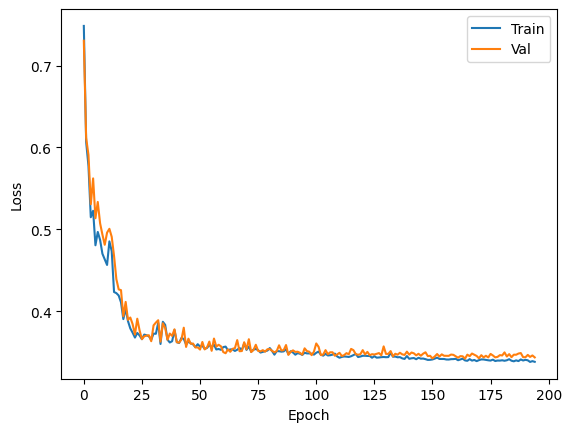

In [386]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [387]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

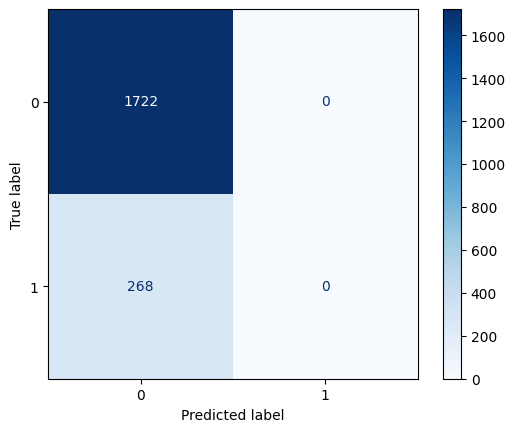

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [388]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### 외곽선에 걸친 샘플 제거

In [112]:
BORDER_COL = 'border boundary length'
df_inside = df[df[BORDER_COL] == 0]
df_inside = df_inside.reset_index(drop=True)

In [113]:
df_inside.shape

(17123, 64)

In [114]:
edges_2 = []
edge_info_2 = df_inside[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info_2):
    df_set = df_inside[df_inside["set_num"] == df_inside.iloc[i]["set_num"]]
    indices_included = df_set["merged ID"].tolist()
    for e in e_list:
        if e in indices_included:
            idx = df_set.index[df_set["merged ID"] == e].tolist()[0]
            new = [i, idx]
            edges_2.append(new)
        
edge_index_2 = torch.Tensor(edges_2).to(dtype=torch.long).t()

In [116]:
df_inside[df_inside["set_num"] == df_inside["set_num"].iloc[-1]][:50]

,merged ID,original grain id,phi1,phi,phi2,merged grain area,parent Area,daughter Area,other area,no. of parent grains,...,Rank for Var4,Rank for Var5,Rank for Var6,neighbor grains count,neighbor grain ids,percent,temperature,speed,direction,set_num
16313,9,9,10.134939,7.609234,51.019148,26,26,0,0,1,...,4,3,6,3,"2,46,59",7,425,1,90,27
16314,10,10,52.390215,355.674708,2.241037,31,31,0,0,1,...,1,4,6,4,"1,4,12,44",7,425,1,90,27
16315,11,11,8.105772,8.579832,53.733370,20,20,0,0,1,...,2,6,5,3,"2,14,59",7,425,1,90,27
16316,13,13,15.607356,323.174189,40.657522,21,21,0,0,1,...,4,6,5,5,"8,12,20,22,36",7,425,1,90,27
16317,17,17,54.604796,354.143851,9.170345,21,21,0,0,1,...,1,4,6,3,"16,28,42",7,425,1,90,27
16318,18,18,24.977943,311.062411,16.112529,15,15,0,0,1,...,6,3,4,1,89,7,425,1,90,27
16319,22,22,30.436445,355.589853,36.563338,66,66,0,0,1,...,6,2,1,5,"13,20,27,36,66",7,425,1,90,27
16320,23,23,15.222485,341.649022,51.687015,72,72,0,0,1,...,2,6,5,4,"16,25,28,56",7,425,1,90,27
16321,24,24,46.440236,356.917186,6.967073,12,12,0,0,1,...,1,5,6,2,"32,44",7,425,1,90,27
16322,25,25,14.047018,314.795996,32.222028,293,293,0,0,1,...,4,6,5,6,"6,16,23,56,80,89",7,425,1,90,27


In [117]:
d = pd.DataFrame(edge_index_2.t())

In [118]:
sum(d.apply(lambda x: set(x), axis=1).value_counts() != 2)

0

In [119]:
y = (df_inside["daughter grains percent"] > 0).map(int).to_numpy()

In [120]:
np.random.seed(1105)

train_ratio = 0.7

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 11985
len(val_indices) = 2568
len(test_indices) = 2570
split done!


In [121]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i-1] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i-1] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i-1] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [123]:
X_train = df_inside.loc[train_mask.numpy(), FEATURE_COLS_COMBINED]
X_val = df_inside.loc[val_mask.numpy(), FEATURE_COLS_COMBINED]
X_test = df_inside.loc[test_mask.numpy(), FEATURE_COLS_COMBINED]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (11985, 37) / (2568, 37) / (2570, 37)
y_train.shape = (11985,) / (2568,) / (2570,)


In [124]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [125]:
X = np.zeros_like(df_inside[FEATURE_COLS_COMBINED])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [126]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index_2,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [127]:
data

Data(x=[17123, 37], edge_index=[2, 83670], y=[17123], train_mask=[17123], val_mask=[17123], test_mask=[17123])

In [128]:
pd.DataFrame(X, columns=FEATURE_COLS_COMBINED).describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,percent,temperature,speed,direction,no. of parent grains,parent Area,daughter Area,other area,other daughters,other daughters area
count,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,...,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000
mean,0.000091,-0.008845,-0.001181,0.003959,0.001663,-0.004465,0.003008,-0.003440,-0.005561,-0.002470,...,-0.000135,-0.006306,-0.007106,-0.004999,0.001539,0.003972,0.001997,0.001178,-0.001249,-0.001520
std,1.006248,1.007257,0.987813,1.036677,1.006943,1.000889,1.010298,0.995232,0.998924,1.004218,...,1.000018,1.002915,1.001933,1.001320,0.978406,1.045869,0.971000,0.955256,0.917844,0.907737
min,-1.146707,-2.397293,-1.037841,-0.392884,-0.930830,-0.954593,-0.741825,-0.992347,-1.416668,-2.546751,...,-0.923563,-1.858679,-1.308023,-1.294304,-0.168452,-0.398878,-0.137489,-0.061509,-0.062160,-0.042847
25%,-0.662429,0.211954,-0.609968,-0.359526,-0.637034,-0.558032,-0.524897,-0.661993,-0.686405,-0.712000,...,-0.923563,-0.555567,-1.308023,-1.294304,-0.168452,-0.364077,-0.137489,-0.061509,-0.062160,-0.042847
50%,-0.133267,0.419341,-0.153048,-0.266702,-0.286277,-0.263945,-0.275430,-0.345437,-0.249297,0.272575,...,-0.923563,-0.121196,0.764512,0.772616,-0.168452,-0.267583,-0.137489,-0.061509,-0.062160,-0.042847
75%,0.623382,0.518119,0.547273,-0.015788,0.282332,0.209386,0.158425,0.281441,0.368762,0.840674,...,1.082763,0.747545,0.764512,0.772616,-0.168452,-0.011321,-0.137489,-0.061509,-0.062160,-0.042847
max,13.093166,0.586332,11.979039,41.818664,12.305729,18.159432,17.317414,10.335580,12.640965,1.259806,...,1.082763,1.616286,0.764512,0.772616,30.103375,45.323315,39.256709,59.951914,54.449387,66.344868


In [131]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


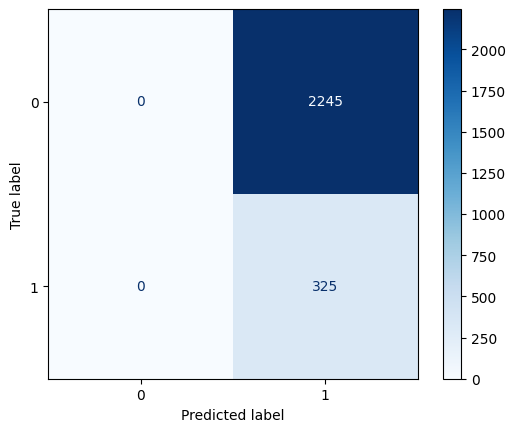

Accuracy: 0.1265
Precision: 0.1265
Recall: 1.0000
f1 score: 0.2245


In [132]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [133]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


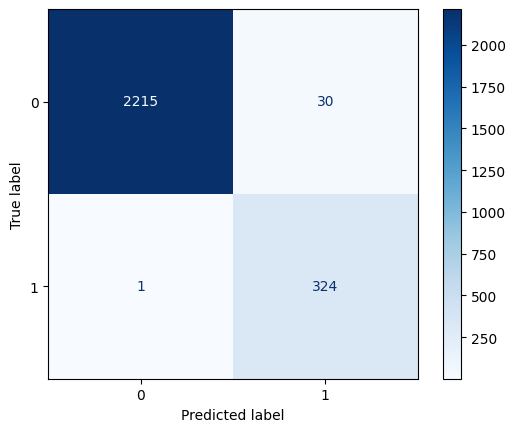

Accuracy: 0.9879
Precision: 0.9153
Recall: 0.9969
f1 score: 0.9543


In [134]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [135]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 5.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


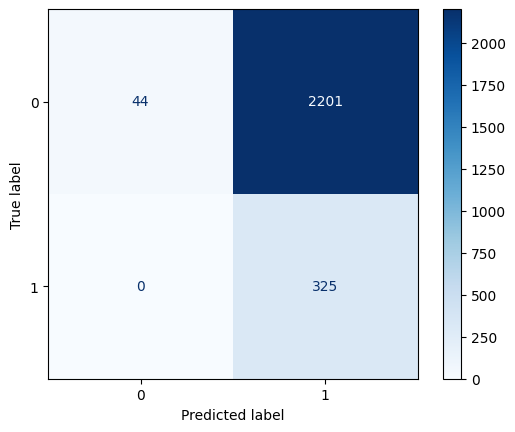

Accuracy: 0.1436
Precision: 0.1287
Recall: 1.0000
f1 score: 0.2280


In [136]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [137]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [138]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,401
MLP model number of params: 342,401


In [139]:
weight = torch.Tensor([1.0, 2.5])
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7374 / Val_loss: 0.4199
Epoch: 002, Train_loss: 0.5138 / Val_loss: 0.3888
Epoch: 003, Train_loss: 0.4263 / Val_loss: 0.3966
Epoch: 004, Train_loss: 0.3961 / Val_loss: 0.4070
Epoch: 005, Train_loss: 0.3917 / Val_loss: 0.4145
Epoch: 006, Train_loss: 0.3945 / Val_loss: 0.4187
Epoch: 007, Train_loss: 0.3985 / Val_loss: 0.4199
Epoch: 008, Train_loss: 0.3973 / Val_loss: 0.4187
Epoch: 009, Train_loss: 0.4006 / Val_loss: 0.4160
Epoch: 010, Train_loss: 0.4022 / Val_loss: 0.4119
Epoch: 011, Train_loss: 0.4001 / Val_loss: 0.4071
Epoch: 012, Train_loss: 0.3985 / Val_loss: 0.4020
Epoch: 013, Train_loss: 0.3972 / Val_loss: 0.3970
Epoch: 014, Train_loss: 0.3955 / Val_loss: 0.3924
Epoch: 015, Train_loss: 0.3899 / Val_loss: 0.3885
Epoch: 016, Train_loss: 0.3896 / Val_loss: 0.3853
Epoch: 017, Train_loss: 0.3907 / Val_loss: 0.3828
Epoch: 018, Train_loss: 0.3868 / Val_loss: 0.3810
Epoch: 019, Train_loss: 0.3882 / Val_loss: 0.3798
Epoch: 020, Train_loss: 0.3872 / Val_loss: 0.3791


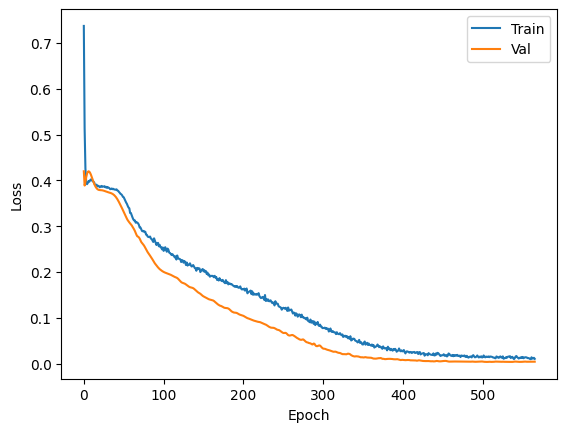

In [140]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

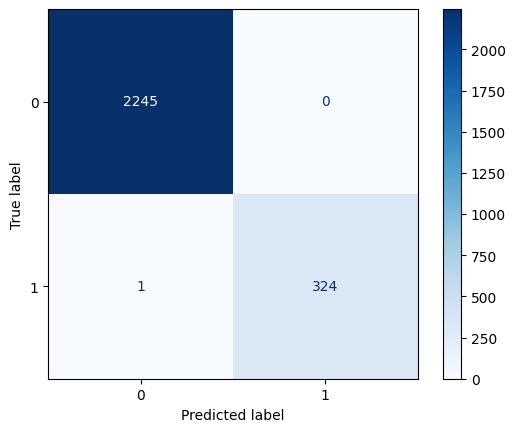

Accuracy: 0.9996
Precision: 1.0000
Recall: 0.9969
f1 score: 0.9985


In [141]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = F.sigmoid(out).round()

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [142]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,401
GCN model number of params: 342,401


In [143]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.6669 / Val_loss: 0.6627
Epoch: 002, Train_loss: 0.4735 / Val_loss: 0.4831
Epoch: 003, Train_loss: 0.4823 / Val_loss: 0.4958
Epoch: 004, Train_loss: 0.4837 / Val_loss: 0.4936
Epoch: 005, Train_loss: 0.4688 / Val_loss: 0.4788
Epoch: 006, Train_loss: 0.4437 / Val_loss: 0.4383
Epoch: 007, Train_loss: 0.4261 / Val_loss: 0.4271
Epoch: 008, Train_loss: 0.4074 / Val_loss: 0.4068
Epoch: 009, Train_loss: 0.4039 / Val_loss: 0.4012
Epoch: 010, Train_loss: 0.4048 / Val_loss: 0.4085
Epoch: 011, Train_loss: 0.4030 / Val_loss: 0.4021
Epoch: 012, Train_loss: 0.4022 / Val_loss: 0.4046
Epoch: 013, Train_loss: 0.3949 / Val_loss: 0.4042
Epoch: 014, Train_loss: 0.3954 / Val_loss: 0.3939
Epoch: 015, Train_loss: 0.3899 / Val_loss: 0.3898
Epoch: 016, Train_loss: 0.3846 / Val_loss: 0.3865
Epoch: 017, Train_loss: 0.3876 / Val_loss: 0.3809
Epoch: 018, Train_loss: 0.3842 / Val_loss: 0.3842
Epoch: 019, Train_loss: 0.3861 / Val_loss: 0.3882
Epoch: 020, Train_loss: 0.3837 / Val_loss: 0.3893


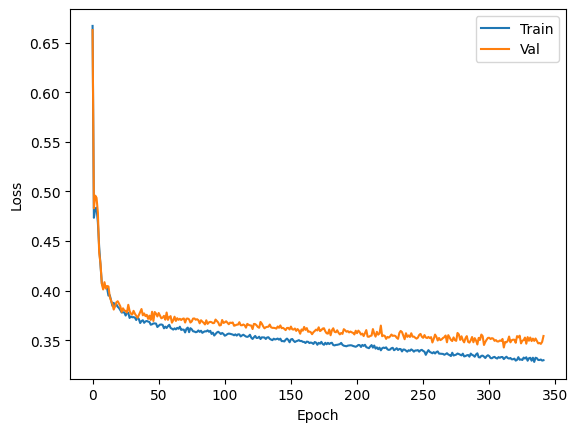

In [144]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [145]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

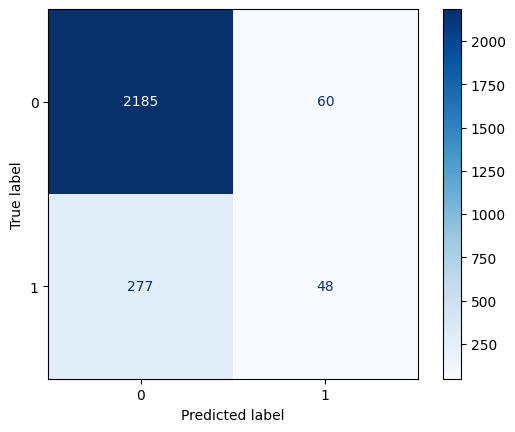

Accuracy: 0.8689
Precision: 0.4444
Recall: 0.1477
f1 score: 0.2217


In [146]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [147]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

345,091
GAT model number of params: 345,091


In [148]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.7613 / Val_loss: 0.7407
Epoch: 002, Train_loss: 0.6618 / Val_loss: 0.6763
Epoch: 003, Train_loss: 0.5760 / Val_loss: 0.5628
Epoch: 004, Train_loss: 0.5240 / Val_loss: 0.5167
Epoch: 005, Train_loss: 0.5120 / Val_loss: 0.5100
Epoch: 006, Train_loss: 0.4928 / Val_loss: 0.4901
Epoch: 007, Train_loss: 0.4686 / Val_loss: 0.4570
Epoch: 008, Train_loss: 0.4501 / Val_loss: 0.4432
Epoch: 009, Train_loss: 0.4539 / Val_loss: 0.4395
Epoch: 010, Train_loss: 0.4442 / Val_loss: 0.4328
Epoch: 011, Train_loss: 0.4393 / Val_loss: 0.4544
Epoch: 012, Train_loss: 0.4398 / Val_loss: 0.4345
Epoch: 013, Train_loss: 0.4474 / Val_loss: 0.4320
Epoch: 014, Train_loss: 0.4436 / Val_loss: 0.4539
Epoch: 015, Train_loss: 0.4126 / Val_loss: 0.4173
Epoch: 016, Train_loss: 0.4135 / Val_loss: 0.4155
Epoch: 017, Train_loss: 0.3972 / Val_loss: 0.3901
Epoch: 018, Train_loss: 0.4038 / Val_loss: 0.3900
Epoch: 019, Train_loss: 0.3870 / Val_loss: 0.3798
Epoch: 020, Train_loss: 0.3926 / Val_loss: 0.3828


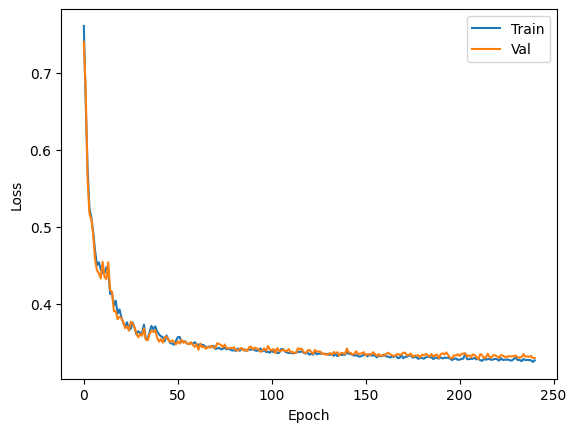

In [149]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

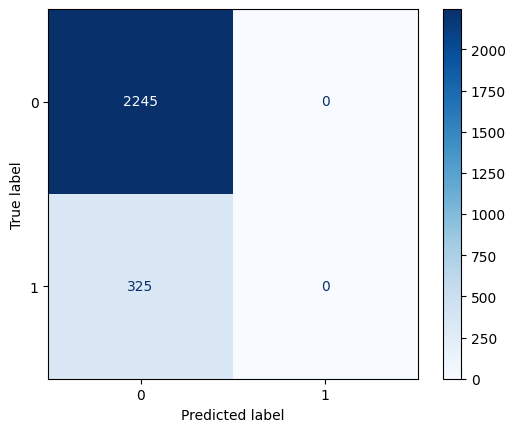

Accuracy: 0.8735
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [150]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [151]:
sum(y) / len(y)

np.float64(0.12702213397185072)